![Presentation Title](imgs/title.png)

# <center> O mnie</center>

![babblelabs](imgs/logo.png)
- programuje (C++, python, Matlab, js ..)



- projektuje (sieci neuronowe, rozwiązania komercyjne)

- badawczo - zajmuję się obrazem (segmentacja audio-wizualna, computer vision)

- na codzień pracuję z dźwiękiem (speech enhancement)

# Babblelabs clearcloud

![babblelabs](imgs/products.png)

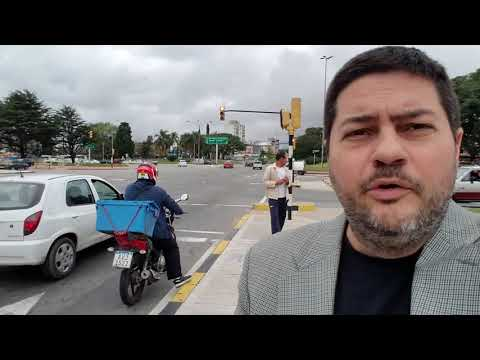

In [107]:
YouTubeVideo('2M8pn1WBB4E')

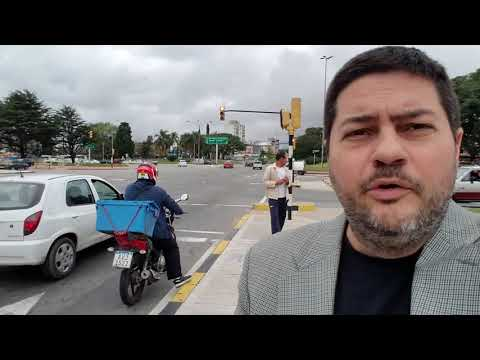

In [108]:
YouTubeVideo('gP6ICPRXV8s')

Segmentacja dźwięku? - po co?

![babblelabs](imgs/segmentacja.jpg)

*src: http://www.technature.ca*

![babblelabs](imgs/supervised-semi.jpg)




In [109]:
- najlepiej supervised
- może być też semi-supervised
- można

SyntaxError: invalid syntax (<ipython-input-109-d093128539a1>, line 1)

Problem - segmentacja (podejście w pełni nadzorowane)



- zalety: można skorzystać z gotowych klasyfikatorów i wykreować nowe zastosowanie
    - pretrenowany model można użyć do bardziej zaawansowanych metod (ImageNet, Facenet)
    - proste i skuteczne


- wady: są lepsze metody, często nienadzorowane
    - zaawansowane funkcje strat
    - triplety, dublety, quadruplety
    - autoenkodery (VAE)
    - podejście generatywne

![babblelabs](imgs/vae.jpg)


![babblelabs](imgs/triplet_loss.png)


Zbiór danych

ISMIR2004 Audio Description Contest - Genre/ Artist ID Classification and Artist Similarity

https://zenodo.org/record/1302992

http://ismir2004.ismir.net/genre_contest/

- muzyczny zbior danych (8GB)
- 8 gatunków muzycznych
- przeznaczony głównie do klasyfikacji
- niekomercyjny



Co potrzebujemy:

- pytorch 0.4.1 (Python)
- librosa (audio processing)
- pandas
- sklearn
- matplotlib

- inne mniej znaczące biblioteki
- gpu
- cierpliwości

In [110]:
import librosa
import librosa.display
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import numpy as np
import pandas as pd

%matplotlib inline

In [111]:
def get_files_list(directory):
    ls = []
    for root, _, files in os.walk(directory, topdown=False):
        for name in files:
            ls.append(os.path.join(root, name))
    ls = list(filter(lambda x : x.split('/')[-1][0] !='.', ls)) #removing .start_file :)
    return ls

In [112]:
import os

DATASET_DIR = './ismir04_genre/audio'
train_dir = os.path.join(DATASET_DIR, 'training')
eval_dir = os.path.join(DATASET_DIR, 'evaluation')

classes = os.listdir(train_dir)
classes = list(filter(lambda x : x[0] !='.', classes))



def seconds_of_file(file_path):
    try:
        dr = librosa.get_duration(filename=file_path)
        dr = int(dr)
    except Exception as e:
        print(f"error with{file_path}")
        dr = 0
    return dr

# Analiza danych

In [113]:
cc = []
for _cls in classes:
    print(_cls)
    files_dir = os.path.join(train_dir, _cls)
    files_list = get_files_list(files_dir)
    cc.extend([{'file_name' : file_name, 'class' : _cls, 'train' : True, 'seconds' : seconds_of_file(file_name)} for file_name in files_list])
    
    
    files_dir = os.path.join(eval_dir, _cls)
    files_list = get_files_list(files_dir)
    cc.extend([{'file_name' : file_name, 'class' : _cls, 'train' : False, 'seconds' : seconds_of_file(file_name)} for file_name in files_list])


pop
metal
world
electronic
classical
error with./ismir04_genre/audio/evaluation/classical/edward_martin/art_of_the_lute_in_renaissance/8-la_tirantine_(le_roy).mp3
rock
punk
jazz


In [114]:
import pandas as pd

df = pd.DataFrame(cc)

print(f"\n{round(df['seconds'].sum()/60/60, 2)} hours")
df.head()


102.05 hours


class                                          file_name  seconds  train
0   pop  ./ismir04_genre/audio/training/pop/the_west_ex...      316   True
1   pop  ./ismir04_genre/audio/training/pop/the_west_ex...      289   True
2   pop  ./ismir04_genre/audio/training/pop/the_west_ex...      281   True
3   pop  ./ismir04_genre/audio/training/pop/the_kokoon/...      246   True
4   pop  ./ismir04_genre/audio/training/pop/the_kokoon/...      289   True

In [ ]:
df[df['train'] == True].to_csv('training.csv')
df[df['train'] == False].to_csv('testing.csv')

In [124]:
sample = df[df['train'] == False]['file_name'].iloc[111]

data, fs = librosa.core.load(sample)
data, fs

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 22050)

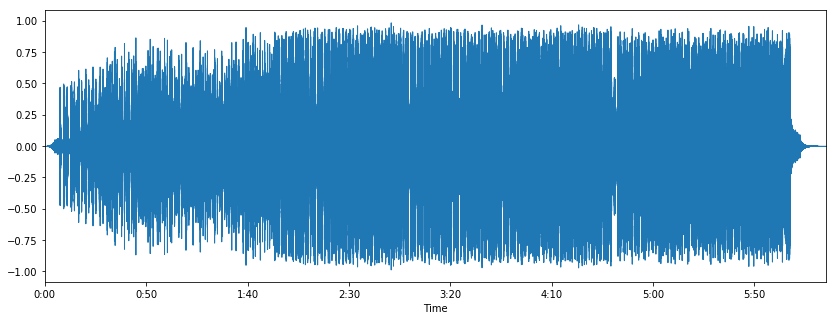

In [125]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(data)

In [126]:
import IPython.display as ipd
ipd.Audio(sample)

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

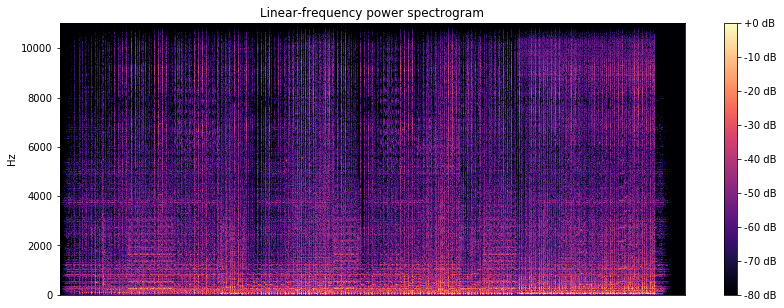

In [127]:
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# <center>Projektowanie potoku przetwarzania</center>

![babblelabs](imgs/jakamelodia.jpg)

In [ ]:
class LibrosaLoader(object):
    def __init__(self, duration=3):
        self.duration = duration
    
    def __call__(self, path, max_size):
        start = np.random.randint(0, max_size-self.duration-1)
        data, _ = librosa.load(path, dtype=np.float32, duration=self.duration, offset=start)
        return data

In [ ]:
class TorchSTFT(object):
    def __init__(self, fft=1024, sr=16000, hop=160, win_length=400):
        self.size = fft
        self.sr = sr
        self.hop = hop
        self.win_l = win_length
        
    def __call__(self, audio_file):
        if len(audio_file.shape) == 1:
            audio_file = np.expand_dims(audio_file, axis=0)
        return self._stft(audio_file[0, :])
    
    def _stft(self, audio_file):
        y = torch.stft(audio_file, n_fft=self.size, hop_length=self.hop, win_length=self.win_l, normalized=True)
        y = y[1:int(self.size/2+1),:,0]
        return y.unsqueeze(0)
    
class ArrayToTensor(object):
    def __call__(self, audio_file):
        ten = torch.from_numpy(audio_file).float()
        ten.unsqueeze_(0)
        return ten
    
    def __repr__(self):
        format_string = self.__class__.__name__
        return format_string

In [ ]:
def cls_to_idx_dict(list_of_speakers):
    list_of_speakers = sorted(list_of_speakers)
    class_to_idx = {list_of_speakers[i]: i for i in range(len(list_of_speakers))}
    return class_to_idx


In [ ]:
class AudioSegmentBaseDataset(Dataset):
    def __init__(self, csv_file, loader, transform=None, sample_audio=None, size=10000):
        self.dataset_df = pd.read_csv(csv_file)
        self.transform = transform
        self.loader = loader
        self.size = size
        self._size_df = len(self.dataset_df)
        
        self.classes = list(self.dataset_df['class'].unique()) 
        self.class_to_idx = cls_to_idx_dict(self.classes)
        print(self.class_to_idx)

    def __getitem__(self, indice):
        sample_index = np.random.randint(0, self._size_df-1)
        row = self.dataset_df.iloc[sample_index]
        
        selected_class = row['class']
        audio_name = row['file_name']
        length = row['seconds']
        cls = self.class_to_idx[selected_class]
        
        audio = self.loader(audio_name, length)

        if self.transform:
            audio = self.transform(audio)

        return audio, cls
    
    def __len__(self):
        return self.size

In [115]:
trs_train = transforms.Compose([ArrayToTensor(),TorchSTFT(fft=512)])

ds_train = AudioSegmentBaseDataset('training.csv', loader=LibrosaLoader(duration=3), 
                                   transform=trs_train, size=4800)

print(len(ds_train))
ds_test = AudioSegmentBaseDataset('testing.csv', loader=LibrosaLoader(duration=3), 
                                  transform=trs_train, size=1600)

print(len(ds_test))


{'classical': 0, 'electronic': 1, 'jazz': 2, 'metal': 3, 'pop': 4, 'punk': 5, 'rock': 6, 'world': 7}
4800
{'classical': 0, 'electronic': 1, 'jazz': 2, 'metal': 3, 'pop': 4, 'punk': 5, 'rock': 6, 'world': 7}
1600


In [116]:
data, index = ds_train[0]
data.size()

torch.Size([1, 256, 414])

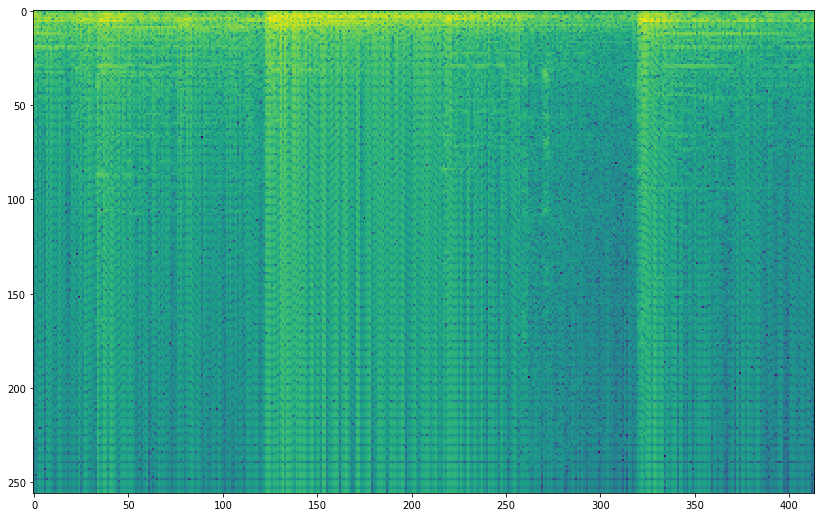

In [117]:
plt.figure(figsize=(14, 14))
data_np = (data).data.numpy()
plt.imshow(np.log(np.abs(data_np[0])))

![babblelabs](imgs/inceptionv3.png)


In [118]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.inception import BasicConv2d

import time

class inception_modified(models.Inception3):

    def __init__(self, num_classes=8):
        self.inplanes = 64
        super(inception_modified, self).__init__(num_classes=num_classes, aux_logits=False)
        self.Conv2d_1a_3x3 = BasicConv2d(1, 32, kernel_size=3, stride=2)
        
        self.emb = nn.Linear(2048, 128)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        emb = F.relu(self.extract_embedding(x), inplace=True)
        out = self.fc(emb)
        return out
        

In [ ]:

    def extract_embedding(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        if self.training and self.aux_logits:
            aux = self.AuxLogits(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)
        x = F.avg_pool2d(x, kernel_size=6)
        x = F.dropout(x, training=self.training)
        x = x.view(x.size(0), -1)

        x = self.emb(x)
        if self.training and self.aux_logits:
            return x, aux
        return x
        
net = inception_modified()

In [119]:
net.forward(ds_train[0][0].unsqueeze(0))

tensor([[-0.1372,  0.0285,  0.0029,  0.1241,  0.0214,  0.2401,  0.0223,  0.0314]],
       grad_fn=<ThAddmmBackward>)

In [120]:
net.extract_embedding(ds_train[0][0].unsqueeze(0)).size()

torch.Size([1, 128])

In [ ]:
def validate(net, data_val_loader, device, criterion, cuda=False):
    with torch.no_grad():
        loss_sum = 0
        total = 0
        correct_top1 = 0
        correct_top5 = 0
        for batch_idx, (inputs, targets) in tqdm(enumerate(data_val_loader)):
            if cuda:
                inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            prec_1, prec_5 = accuracy_top1_5(outputs, targets, topk=(1, 5))
            correct_top1 += prec_1
            correct_top5 += prec_5
            loss = criterion(outputs, targets)
            loss_sum += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            
    return loss_sum, correct_top1, correct_top5, total

In [ ]:
def set_seeds_for_workers(worker_no):
    np.random.seed()
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy_top1_5(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k)
    return res


def show_metrics(prefix, index, size, loss_sum, performance):
    print(prefix + "Iter %d, size %d, loss %6.6f, performance %3.2f percent" % (
        index, size, loss_sum, 100.0 * performance))

    

In [ ]:
cuda = False
batch_size = 16
net = inception_modified()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
if cuda:
    net = net.cuda()
    cudnn.benchmark = True
    
net.to(device)
   
optimizer = optim.SGD(net.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.cuda()
print("Criterion {} ".format(criterion))
    
data_train_loader = DataLoader(ds_train, batch_size,
                               num_workers=8, pin_memory=True, worker_init_fn=set_seeds_for_workers)
data_val_loader = DataLoader(ds_test, batch_size, 
                             num_workers=8, pin_memory=True, drop_last=True, worker_init_fn=set_seeds_for_workers)
    
print(len(ds_train), len(ds_test))

number_of_epochs = 100
loss_sum = 0
correct = 0
total = 0
iteration = 0

In [ ]:
checkpoint = torch.load('classifier_1.pth')
net.load_state_dict(checkpoint)

# Trenowanie

In [ ]:
for epoch in range(0, epochs):
    net.train()
    
    for batch_idx, (inputs, targets) in enumerate(data_train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
            
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_batch = loss.item()
        
        
    output_path = './classifier'  + "_" + str(epoch) + '.pth'
    print("saving to %s" % (output_path))
    torch.save(net.state_dict(), output_path)

In [ ]:
%matplotlib notebook

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

# Embeddings

![babblelabs](imgs/vector-space.png)


In [121]:
def do_plot(X_fit, labels, title=None):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.tab10_r(np.linspace(0, 1, num_labels))
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           c=col, label='%s' % lab)
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=col, label='%s' % lab)
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        plt.legend()
        plt.show()

In [ ]:
x = []
y = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in tqdm(enumerate(data_val_loader)):
        print(batch_idx)
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net.extract_embedding(inputs)

        x.append(outputs.cpu().data.numpy())
        y.append(targets.cpu().data.numpy())

In [ ]:
X_ind = np.concatenate(x)
Y_ind = np.concatenate(y)

x_new = []
y_new = []
for i in range(8):

    ind = np.where(Y_ind == i )
    y_new.append(Y_ind[ind])
    x_new.append(X_ind[ind])
    
X_ind = np.concatenate(x_new)
Y_ind = np.concatenate(y_new)
    
print(X_ind.shape, Y_ind.shape)

set(Y_ind)

In [ ]:
tsne2 = TSNE(n_components=2, random_state=0)
tsne2x = tsne2.fit_transform(X_ind)

In [ ]:
do_plot(tsne2x, Y_ind, 't-SNE - 2d embeddings 128x1')

# Wyniki 

- kilka epok, 50%
- relacje między klasami (tutaj klasyczna i rock)
![babblelabs](imgs/poor.png)


## Wyniki (prywatne)

- tydzień liczenia
- uśrednianie embeddingów
- dodatkowe dane wejściowe
- normalizacje
- zbiór danych 1000h
- trochę lepsze znakowanie

![babblelabs](imgs/better-triplet.png)


## Wyniki - mnist (softmax)

![babblelabs](imgs/softmax-mnist.png)


In [ ]:
pca2d = PCA(n_components=2, random_state=0)
pca2dx = pca2d.fit_transform(X_ind)


In [ ]:
do_plot(pca2dx, Y_ind, 'pca2d - embeddings 128x1')


# Klasteryzacja!

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# i wykres
plt.scatter(tsne2x, Y_ind, c=y_kmeans, s=50, cmap='viridis')

# Podsumowanie

- warto zainteresować się VAE i dodatkowymi danymi wejściowymi (w dziedzinie spektralnej np. CQT)

- 3 sekundy to zdecydowanie za mało

- pretrenowane klasyfikatory można wykorzystać do innych zadań

![babblelabs](imgs/logo.png)

# <center> rpilarczyk@babblelabs.com </center>

<b><center> Prezentacja dostępna tutaj https://github.com/stihl1210 </center></b>